In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm

We got equations: 
$$
\begin{cases}
\frac{dG}{dt} = p_1 G + p_2 X + p_3 \\
\frac{dX}{dt} = G + p_4 X
\end{cases}
$$

Let's first generate G

In [2]:
def find_g(p1, p2, p3, p4, p5, X0, T, step=1):
    '''
    Modelat G with given parameters
    '''
    g = [p5]
    x = [X0]
    
    for _ in range(int(T * step)):
        dg_dt = p1 * g[-1] + p2 * x[-1] + p3
        dx_dt = g[-1] + p4 * x[-1]
        
        g.append(g[-1] + dg_dt / step)
        x.append(x[-1] + dx_dt / step)
        
    return np.array(g), np.array(x)

In [3]:
# p1 = 1.87 / 100
p1 = -0.05
p2 = -1.25 / 100
p3 = 9.21
p4 = -1.97 / 10

p5 = 150
X0 = 80

In [104]:
step = 60
T = 60
G, X = find_g(p1, p2, p3, p4, p5, X0, T, step)

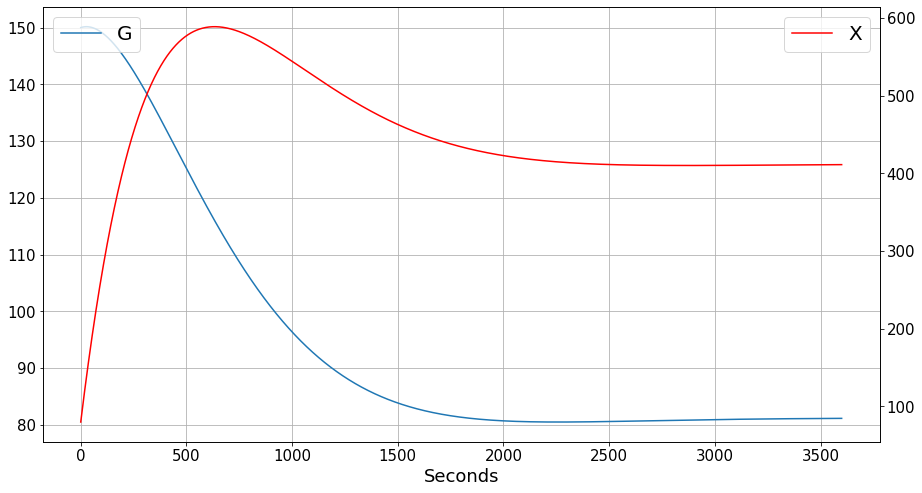

In [105]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.rc('ytick',labelsize=15)
plt.rc('xtick',labelsize=15)

plt.plot(G, label='G')
plt.xlabel('Seconds', fontsize=18)
plt.legend(loc='upper left', prop={'size': 20})
plt.grid()

ax = ax.twinx()
plt.plot(X, label='X', color='r')

plt.legend(prop={'size': 20})

Let's find error of simulation:


In [116]:
errors = []
coefs_ = tqdm(np.arange(1, 100, 1)):
for coef_ in coefs_:
    G1, X1 = find_g(p1, p2, p3, p4, p5, X0, T, step * coef_)
    errors.append((abs((G - G1[::coef_]) / G)).mean() * 100)

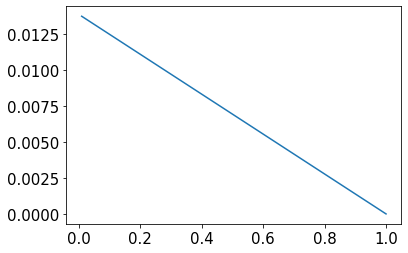

In [122]:
plt.plot(1. / coefs_, errors)

In [126]:
m = LinearRegression().fit((1. / coefs_).reshape(-1, 1), errors)

print("Error:", m.intercept_, "%")

Error: 0.013895940170233129 %


Let's find parameters when we know X and G

p_4

In [6]:
Y = (X[::step][1:] - X[::step][:-1] - G[::step][1:]) * 1
Z = X[::step][:-1].reshape((-1, 1))

model = LinearRegression(fit_intercept=False).fit(Z[:], Y[:])
y_pred = model.predict(Z[:])
r2_score(y_pred, Y), model.coef_, model.intercept_

(0.9791455376652736, array([-0.1960901]), 0.0)

In [7]:
model.coef_[0] - p4

0.000909897798801268

p_1, p_2, p_3

In [8]:
Y = (G[::step][1:] - G[::step][:-1]) * 1
Z = np.vstack([G[::step][:-1], X[::step][:-1]]).T

model = LinearRegression().fit(Z[:], Y[:])
y_pred = model.predict(Z[:])
r2_score(y_pred, Y), model.coef_, model.intercept_

(1.0, array([-0.05437267, -0.01105665]), 8.970197628658195)

In [9]:
print(model.coef_[0] - p1)
print(model.coef_[1] - p2)
print(model.intercept_ - p3)

-0.004372665152640225
0.001443345871062443
-0.23980237134180626


Let's prove numerically that this problem non-identifiable. To do so we'll find infinite number parameters for the same G that fit equations

In [88]:
def get_params_basic(p4, G, X0, step):
    '''
    For given G, p_4 and X(0) find p_1, p_2 and p_3 that fit equations and r2_score of that fit
    '''

    X_ = [X0]

    #find X from second equation
    for g in G[:-1]:
        dx_dt = g + p4 * X_[-1]
        X_.append(X_[-1] + dx_dt / step)

    #find p1, p2, p3 from first equation
    Y = (G[1:] - G[:-1]) * step
    Z = np.vstack([G[:-1], X_[:-1]]).T

    model = LinearRegression().fit(Z[:], Y[:])
    y_pred = model.predict(Z[:])
           
    return r2_score(y_pred, Y), model.coef_, model.intercept_

def get_params_pro(p4, G, X0, step):
    '''
    For given p4 and G trying to find X0 (close to one that user defined), so r2_score is best
    Print that r2_score and return p_1, p_2, p_3
    '''
    grid = np.arange(0.5, 2.001, 0.05)
    r2_scores = [get_params_basic(p4, G, X0 * coef, step)[0] for coef in grid]
    best_coef = grid[np.argmax(r2_scores)]
    res = get_params_basic(p4, G, X0 * best_coef, step)
    print("R2 score of fit:", round(res[0], 4))
    
    return res[1:], X0 * best_coef

Now for different $p_4$ we'll find different $p_1, p_2, p_3$ that fit equations

In [91]:
res = []
for p4_ in np.arange(0.25, 1.2, 0.05) * p4:
# for p4_ in [p4]:
    print("p_4={}".format(round(p4_, 4)),end=' ')
    ([p1_, p2_], p3_), X0_ = get_params_pro(p4_, G[::step], X0, 1)
    res.append([p1_, p2_, p3_, p4_, X0_])
res = np.array(res)

p_4=-0.0492 R2 score of fit: 0.9861
p_4=-0.0591 R2 score of fit: 1.0
p_4=-0.069 R2 score of fit: 0.9947
p_4=-0.0788 R2 score of fit: 0.9899
p_4=-0.0886 R2 score of fit: 0.9882
p_4=-0.0985 R2 score of fit: 0.9886
p_4=-0.1083 R2 score of fit: 0.9901
p_4=-0.1182 R2 score of fit: 0.9921
p_4=-0.128 R2 score of fit: 0.9941
p_4=-0.1379 R2 score of fit: 0.996
p_4=-0.1478 R2 score of fit: 0.9976
p_4=-0.1576 R2 score of fit: 0.9988
p_4=-0.1674 R2 score of fit: 0.9996
p_4=-0.1773 R2 score of fit: 1.0
p_4=-0.1871 R2 score of fit: 1.0
p_4=-0.197 R2 score of fit: 1.0
p_4=-0.2068 R2 score of fit: 0.9998
p_4=-0.2167 R2 score of fit: 0.9992
p_4=-0.2266 R2 score of fit: 0.9984


Here you can see how parameters change

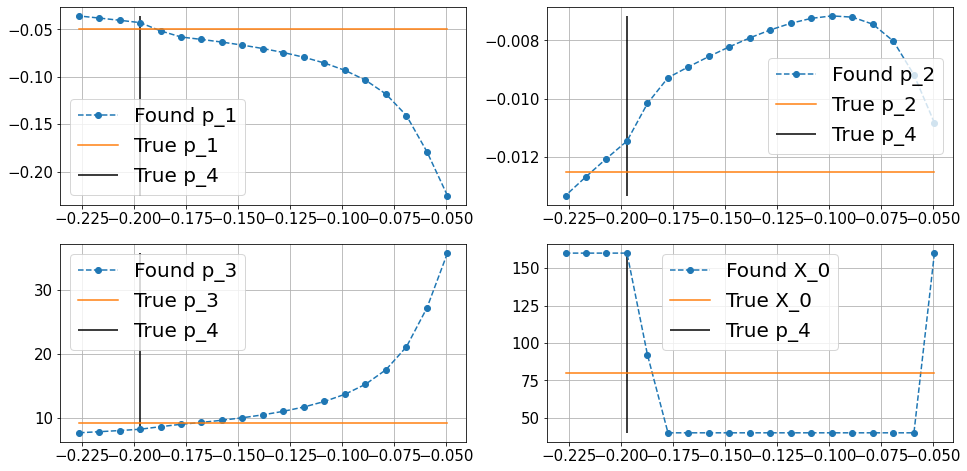

In [99]:
fig = plt.figure(figsize=(16, 8))
# plt.rc('ytick',labelsize=15)
# plt.rc('xtick',labelsize=15)

fig.add_subplot(221)
plt.plot(res[:, 3], res[:, 0], linestyle='--', marker='o', label='Found p_1')
plt.plot(res[:, 3], [p1] * len(res[:, 3]), label='True p_1')
plt.vlines(p4, min(res[:, 0]), max(res[:, 0]), label='True p_4')
plt.grid()
plt.legend(prop={'size': 20})

fig.add_subplot(222)
plt.plot(res[:, 3], res[:, 1], linestyle='--', marker='o', label='Found p_2')
plt.plot(res[:, 3], [p2] * len(res[:, 3]), label='True p_2')
plt.vlines(p4, min(res[:, 1]), max(res[:, 1]), label='True p_4')
plt.grid()
plt.legend(prop={'size': 20})

fig.add_subplot(223)
plt.plot(res[:, 3], res[:, 2], linestyle='--', marker='o', label='Found p_3')
plt.plot(res[:, 3], [p3] * len(res[:, 3]), label='True p_3')
plt.vlines(p4, min(res[:, 2]), max(res[:, 2]), label='True p_4')
plt.grid()
plt.legend(prop={'size': 20})

fig.add_subplot(224)
plt.plot(res[:, 3], res[:, 4], linestyle='--', marker='o', label='Found X_0')
plt.plot(res[:, 3], [X0] * len(res[:, 3]), label='True X_0')
plt.vlines(p4, min(res[:, 4]), max(res[:, 4]), label='True p_4')
plt.grid()
plt.legend(prop={'size': 20})
# plt.plot(res[:, 1], linestyle='--', marker='o', label='p_2')
# plt.plot(res[:, 3], linestyle='--', marker='o', label='p_4')
# plt.plot(res[:, 4], linestyle='--', marker='o', label='X_0')
# plt.legend(loc='lower left', prop={'size': 20})

plt.legend(prop={'size': 20})

Accuracy

In [100]:
errors = []
for params in res:
    G1, X1 = find_g(params[0], params[1], params[2], params[3], p5, params[4], T, step)
    errors.append((abs((G - G1) / G)).mean() * 100)
max(errors)

1.2544865242960341

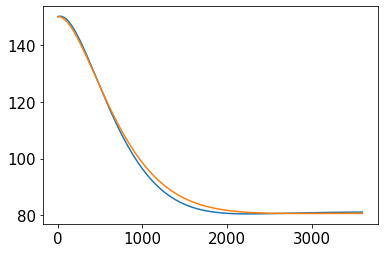

In [101]:
plt.plot(G)
plt.plot(G1)

## So we can see that for one G there could be several $p_1, p_2, p_3, p_4$ that fit equations. So parameters is non-identifiable 

Let's now show that model is observable

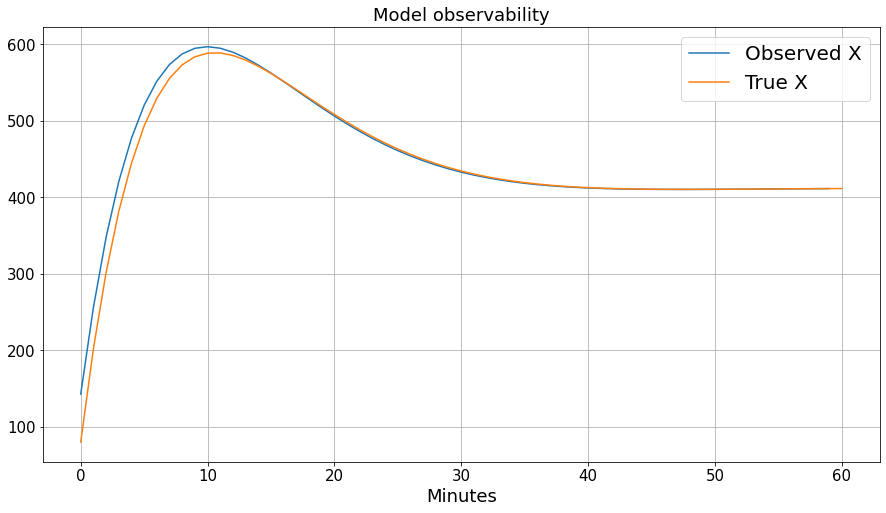

In [66]:
plt.figure(figsize=(15, 8))
plt.rc('ytick',labelsize=15)
plt.rc('xtick',labelsize=15)

plt.plot(((G[::step][1:] - G[::step][:-1]) * 1 - p1 * G[::step][1:] - p3) / p2, label='Observed X')
plt.plot(X[::step], label='True X')
plt.xlabel("Minutes", fontsize=18)
plt.title("Model observability", fontsize=18)
plt.grid()
plt.legend(prop={'size': 20})

In [137]:
mape = ((G[::step][1:] - G[::step][:-1]) * 1 - p1 * G[::step][1:] - p3) / p2 
mape = (abs((mape - X[::step][:-1])/ X[::step][:-1])).mean() * 100
print("MAPE:", mape, '%')

MAPE: 2.7870150747597586 %


In [138]:
steps = np.arange(1, 60, 1)
errors = []

for step_ in steps:
    pred = ((G[::step_][1:] - G[::step_][:-1]) * step / step_ - p1 * G[::step_][1:] - p3) / p2 
    err = (abs((pred - X[::step_][:-1]) / X[::step_][:-1])).mean() * 100
    errors.append(err)

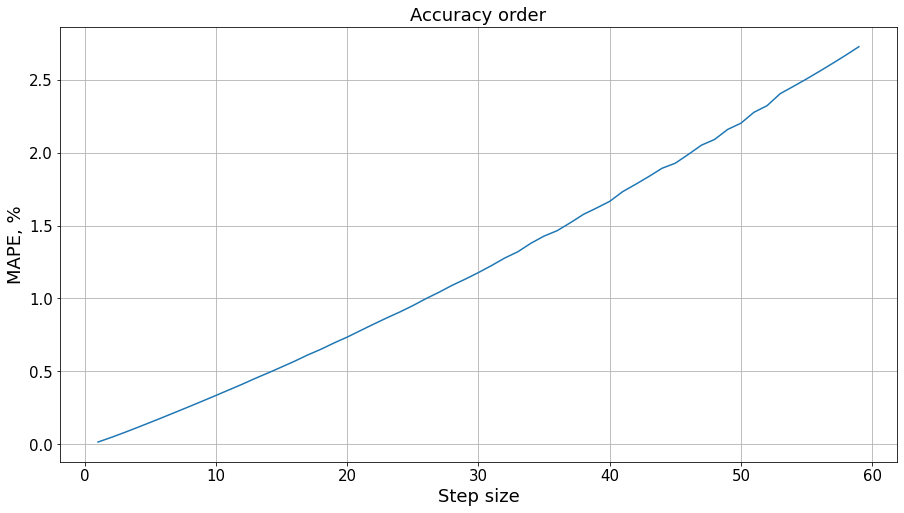

In [139]:
plt.figure(figsize=(15, 8))
plt.rc('ytick',labelsize=15)
plt.rc('xtick',labelsize=15)

plt.xlabel("Step size", fontsize=18)
plt.ylabel("MAPE, %", fontsize=18)
plt.title("Accuracy order", fontsize=18)

plt.grid()
plt.plot(steps, errors)

## TODO
1) Find limit value of G theoretically (by equation)

2) Tune p_1 (0-6) so that it fits limit value 

3) Do 1) for all models

## Task 1

If exists limit for G and X, let's call them $\hat{G}$ and $\hat{X}$. Then we have following equations:
$$
\begin{cases}
p_1 \hat{G} + p_2 \hat{X} + p_3 = 0 \\
\hat{G} + p_4 \hat{X} = 0
\end{cases}
$$
One could solve it:
$$
\begin{cases}
\hat{X} = \frac{p_3}{p_1 p_4 - p_2} \\
\hat{G} = \frac{-p_3 p_4}{p_1 p_4 - p_2}
\end{cases}
$$

Let's find $\hat{G}$:

In [7]:
-p3 * p4 / (p1 * p4 - p2)

205.80188518732774

## Task 2

We can find proper $p_1$, so that $\lim{G}=80$:

In [8]:
p2 / p4 - p3 / 80

-0.051673223350253816